#Estimation of Covariance Matrices.
By Christopher van Hoecke and Max Margenot.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

---

<center>"Fragility is the quality of things that are vulnerable to volatility" - N. Taleb. </center>
--

Volatility has for long been a thorn in the side of many investors attempting to beat and thrive in the markets. Successfully minimizing volatility would theoretically allow for more accurate modeling of the returns and more stable investments, which translate into greater returns. 

#Covariance.
Measuring volatility in a portfolio can sometimes be a challenge. It involves multiple assets, with different weights, reacting rapidly to the changes in the markets. Because of it's high volatility, it becomes increasingly difficult to accurately model returns, and predict them which is limiting for a portfolio manager. Covariance becomes a very important aspect of portfolio and risk management. The relation between two or more assets movement's with respect to each other provides valuable insights, and a path towards reduction of portfolio volatility, since having assets with low covariance would assure they decrease or increase independently of each other thus reducing the amplitude of movement, which impacts our portfolio's volatility.

##Definition. 
In statistics and probability, the covariance is used to quantify how much two random variables move with respect to one another. It can be assimilated to the variance of two **different** data sets as opposed to of the elements in **one**.   
Mathematically, we express the covariance of X with respect to Y as:

$$ cov(X, Y) = E\{(X - E(X))(Y - E(Y))\}$$

*Which is read as the "covariance of X, Y equals the expected value of X minus the expected value of X multiplied by Y minus the expected value of Y."*

The reason for the covariance's popularity in finance are diverse ranging from Portfolio theory to Risk management. It has been the backbone of Modern Portfolio theory which relies on the simple idea that having two assets with very high covariance provides little diversification.

In [38]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.covariance as sc

We will start our study of the covariance with a simple example. Taking two highly dependable datasets: $y =  5x + c$, where c is normally distributed random constants (noise), and computing the covariance using the formula above, we get a clear picture of how asset x evolves with respect to asset y.

In [186]:
# Generate Random-Normal values of x
x = np.random.normal(size = 1000)
noise = np.random.normal(0, 3, size = len(x))
y = (5 * x) + noise 

product = (x - np.mean(x))*(y - np.mean(y))
expected_value = np.mean(product)

print 'Value of the covariance between x and y:', expected_value

1000
Value of the covariance between x and y: 5.26707001725


Our covariance value of about 5 could have been anticipated from our formula for y but what does it mean physically? A crude physical way of looking at it is *"for every jump x makes from square 0 to 1, y will jump from square 0 to 5.* Printing a scatter plot of x and y, we can clearly see this. For each value of x in the horizontal axis, we read a value of y on the vertical axis. The linear relationship we can see in the scatter plot allows us to see that when x goes to square 1, y goes to square 5. 

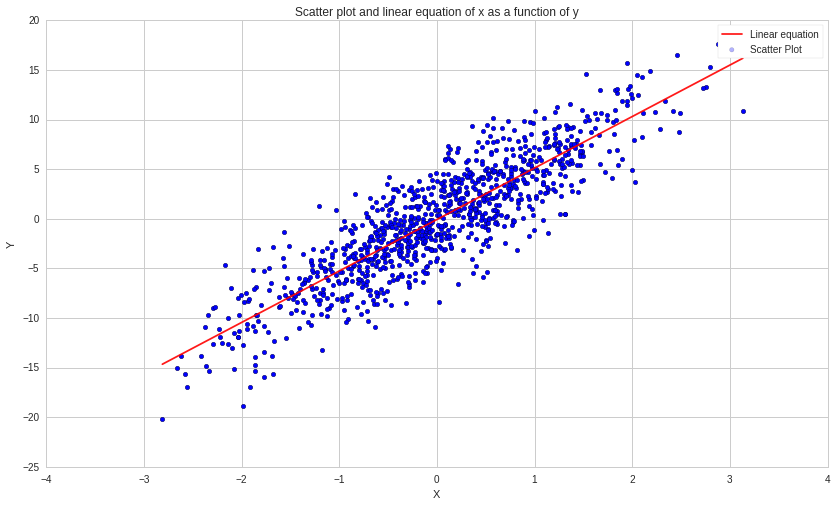

In [213]:
# scatter plot of X and y
from statsmodels import regression
import statsmodels.api as sm
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

linreg(x, y)
plt.scatter(x, y)
plt.title('Scatter plot and linear equation of x as a function of y')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(['Linear equation', 'Scatter Plot']);

While it is feasible to calculate the covariance by manual labour, numpy allows us to calculate it automatically using the `np.cov()` function. We use that function bellow to find the covariance of our set x and y.

In [270]:
# Finding covariance of x, y using Numpy.
covariance = np.cov(x, y)
print "Numpy's calculation of covariance:\n", covariance

Numpy's calculation of covariance:
[[  1.01613043   5.27234236]
 [  5.27234236  35.61581467]]


##The Covariance Matrix.
The output of the `np.cov()` is not a single value for covariance as we had calculated but an array (matrix). What are the other three values? Notice that the two off-diagonal elements are equal, and to the value of covariance we had previously calculated. By deduction, we can say that the off diagonal elements of the matrix are the covariance. What then are the remaining two values? If you run the `np.var()` function, you will find them to be the variance of x and y respectively.   
This is called the Covariance-Variance matrix, or simply the Covariance matrix and is an elegant solution to a simple problem - Efficiently express the covariance of multi-variables. We define it mathematically as:  

$$
   \Sigma=
  \left[ {\begin{array}{cccc}
   var_{i}   & cov_{j,i} & cov_{k,i} & \dots \\
   cov_{i,j} & var_{j}   & cov_{k,j}     & \dots\\
   cov_{i,k} & cov_{j,k} & var_{k}   & \dots \\
   \dots     &\dots      &\dots      &var_{n}\\
  \end{array} } \right]
$$    

When trying to find the covriance of multiple assets, it quickly becomes apparent why the matrix notation is more favorable than performing different computations one by one. 

In [148]:
# Four asset example of the covariance matrix.
start = '2015-01-01'
end = '2017-01-01'

dataset1 = get_pricing('SBUX', 
                       start_date = start, 
                       end_date = end, 
                       fields = 'open_price').pct_change()[1:]
dataset2 = get_pricing('AAPL', 
                       start_date = start, 
                       end_date = end, 
                       fields = 'open_price').pct_change()[1:]
dataset3 = get_pricing('GS', 
                       start_date = start, 
                       end_date = end, 
                       fields = 'open_price').pct_change()[1:]
dataset4 = get_pricing('GILD', 
                       start_date = start, 
                       end_date = end, 
                       fields = 'open_price').pct_change()[1:]

# Create a 2D array of the four datasets (array of arrays). 
x = pd.concat([dataset1, dataset2, dataset3, dataset4], 
              axis = 1)

# We need to take the Transpose of the matrix in order to get
# The desired dimentions. Remember the matrix must be n x n, 
# where n is the number of assets. 
print 'Covariance matrix of SBUX, AAPL, GS, GILD: \n'
print np.cov(x.T)

Covariance matrix of SBUX, AAPL, GS, GILD: 

[[ 0.00024615  0.00017087  0.00011646  0.00015076]
 [ 0.00017087  0.00035485  0.00012619  0.00016081]
 [ 0.00011646  0.00012619  0.00021304  0.00012089]
 [ 0.00015076  0.00016081  0.00012089  0.00033169]]


##Why does all this matter?  
As discussed earlier in the lecture, the covariance is a great way of making sure our portfolio does not succumb to market crashes and volatility. This is mainly done through the process of portfolio optimization. It is defined as choosing the right weights for each asset in our portfolio such that it performs better given certain criterion. The most notable methods for portfolio optimization are: Mean-Variance, Min-Variance, Inverse-Variance, and Risk-Parody. All these methods use the covariance matrix to find the ideal weights for an optimal risk-return ratio. *Reference [this](https://www.quantopian.com/posts/hierarchical-risk-parity-comparing-various-portfolio-diversification-techniques) post on hierarchical risk parity for more complex optimization techniques. *   
The one technique of interest to us is the Mean-Variance technique, which implies $\text{minimizing : } x' \Sigma x$ with respect to certain constraints. *See section on mean-variance optimization for more detail*.

Estimating the covariance matrix becomes especially important when talking about these portfolio techniques; an unstable covariance matrix such as the sample matrix would lead to greater turnover rates, which equate to lower returns. It becomes important to limit the extreme values of the sample covariance matrix to reduce volatility of the associated asset weights.  

----

#The Shrinkage Estimation. 

In the context of portfolio optimization, $\Sigma$ becomes challenging to find. Using the **sample** covariance is feasible, but as discussed above, it is highly dependent on the data, and will vary a lot in time. Furthermore, the sample matrix tends to fail when the number of population begin to exceed the number of observations (N > P).  
For this reason, we use a technique called Shrinkage to find the **estimated** covariance matrix that would theoretically remedy the undesirable traits posed by the **sample** covariance matrix. 


##Shrinkage. 
The concept of shrinkage spawns from a desire to have a more stable covariance matrix, this entails reducing the extreme values of the sample covariance matrix by pulling them closer to the center, thus 'shrinking' the sample matrix. There exist multiple techniques for finding the estimated covariance matrix. In finance however, the most effective and most widely used method is the **shrinkage method**. It is defined as a linear combination of the "sample estimator" and "another estimator". In other words, we take the sample covariance matrix and attempt to shrink it with respect to a constant.
Given a sample covariance matrix $\textbf{S}$ and the mean $\mu$ the shrunk estimated covariance is mathematically defined as   

$$
(1 - \delta)\textbf{S} + \delta\mu\textbf{1}
$$  
 
$\delta$ is defined as the shrinkage constant such that, $0 \leq \delta \leq 1$, which translates to the 'weight that is given to the estimator'.

The value at which we should shrink the covariance matrix has been the course of multiple studies and publications. We go over a few techniques bellow using the scikit-learn library.

##Ledoit-Wolf Estimator.
The goal of the Ledoit-Wolf shrinkage technique is finding an optimal value of $\delta$ with which to shrink the sample covariance matrix to find the most stable version of the matrix. You can read more about their derivation of the value in their [paper](http://www.ledoit.net/honey.pdf). In this lecture, we content ourselves with knowing that $\hat\delta^{\ast}$ is defined as $max\Big\{0, min\big\{\frac{\hat\kappa}{T},1\big\}\Big\}$, where $\hat\delta^{\ast}$ is the optimal shrinkage constant. 

We can use the scikit learn library, and the `sc.ledoit_wolf()` function to find the shrunk matrix along with the shrinkage constant used. You can run `help(sc.ledoit_wolf)` to learn more about the parameters of the function. We run it bellow on both in and out of sample data for returns of 6 assets, setting the `assume_centered` parameter to false, and calculate the mean error associated with the shrunk covariance matrix, which we define bellow.

In [54]:
# Getting the return data of assets. 
start = '2003-01-01'
end = '2003-05-01'

new_start = '2003-05-01'
new_end = '2003-10-01'

symbols = ['AAPL', 'MSFT', 'BRK-A', 'GE', 'FDX', 'SBUX']

pricing_sample = get_pricing(symbols, start_date = start, end_date = end, fields = 'open_price')
pricing_sample.columns = map(lambda x: x.symbol, pricing_sample.columns)
returns = pricing_sample.pct_change()[1:]

# Concatenate data into an array
in_datalist = pd.concat([returns['AAPL'], returns['MSFT'], returns['BRK_A'], 
                         returns['GE'], returns['FDX'], returns['SBUX']],
                         axis = 1).values


pricing_sample = get_pricing(symbols, start_date = new_start, end_date = new_end, fields = 'open_price')
pricing_sample.columns = map(lambda x: x.symbol, pricing_sample.columns)
returns = pricing_sample.pct_change()[1:]

# Cocatenate into an array
out_datalist = pd.concat([returns['AAPL'], returns['MSFT'], returns['BRK_A'], 
                          returns['GE'], returns['FDX'], returns['SBUX']],
                         axis = 1).values

Now that we have our in and out of sample returns for the 6 assets, we can set about calcualting the two shrunk covariance matrices: The in and out of sample ones . 

In [214]:
# Calculate the in sample and out of sample Ledoit-Wolf Shrunk covariance matrix
# Print out the matrix and the Shrinkage Constant. 
# Setting assume_centered parameter to False. 

in_lw_matrix, in_shrinkage = sc.ledoit_wolf(in_datalist, assume_centered = False)
print 'In sample Shrinkage Constant:', in_shrinkage

out_lw_matrix, out_shrinkage = sc.ledoit_wolf(out_datalist, assume_centered = False)
print 'Out sample Shrinkage Consntant:', out_shrinkage

In sample Shrinkage Constant: 0.0756702876689
Out sample Shrinkage Consntant: 0.0762780218182


### Calculating Errors
We can quantify the variance between the in and out of sample matrices by taking the mean difference element by element for the two matrices. We represent it mathematically as: 
$$
\nu = \frac{1}{n} \sum_{i=1}^{n} |a_i - b_i|
$$

In [215]:
# Calculating the mean error associated with the OAS method. 
lw_error = np.mean(sum(abs(np.subtract(in_lw_matrix, out_lw_matrix))))
print 'Mean error for the Ledoit-Wolf Shrunk Covariance Matrix:', lw_error

Mean error for the Ledoit-Wolf Shrunk Covariance Matrix: 0.000630113613455


### Comparing to Sample Matrix
We can check the validity of the shrinkage technique by comparing the results for the shrunk covariance matrix to that of the sample one which we calculate bellow.

In [226]:
in_sample_matrix = np.cov(in_datalist.T)
out_sample_matrix = np.cov(out_datalist.T)
sample_error = np.mean(sum(abs(np.subtract(in_sample_matrix, out_sample_matrix))))
print 'Mean error associated with the sample covariance matrix:', sample_error

Mean error associated with the sample covariance matrix: 0.000684748532079


We can see that the mean error associated with the Ledoit-Wolf shrunk matrix is smaller than that of the sample shrunk covariance by a factor of about 10%. This translates into decreased volatility and turnover rate in our portfolio, and thus increased returns when using the shrunk covariance matrix. 

##OAS Estimator. 
The Oracle Approximating Shrinkage Estimator is another shrinkage technique built upon the Ledoit-Wolf technique. Its aim is to optimize the shrinkage constant by minimizing the Mean Square Error. The formula for the shrunk covariance matrix remains the same :  

$$
(1 - \delta)\textbf{S} + \delta\mu\textbf{1}
$$

But the optimal shrinkage constant $\hat\delta^\ast$ used in the Ledoit-Wolf method is changed for the more optimal value, found to be 

$$
\hat\delta^\ast = \frac{E \big\{ (\Sigma - \bf{\hat S})^T(\bf{\hat F} - \bf{\hat S}) \big\}}
{E\big\{|\bf{\hat S} - \bf{\hat F}|^2_F \big\}}
$$
Where $\textbf{F}$ the matrix : 

$$
   \ \textbf{F}=
  \left[ {\begin{array}{cccc}
   s_{ii}   & \bar r \sqrt{s_{ii}s_{jj}} & \bar r \sqrt{s_{ii}s_{kk}} & \dots \\
   \bar r \sqrt{s_{jj}s_{ii}} & s_{jj}   & \bar r \sqrt{s_{jj}s_{kk}}    & \dots\\
   \bar r \sqrt{s_{kk}s_{ii}} & \bar r \sqrt{s_{kk}s_{jj}} & s_{kk}   & \dots \\
   \dots     &\dots      &\dots      &var_{n}\\
  \end{array} } \right]
$$    

where s denotes the elemnent of the sample matrix, and 
$\bar r = \frac{2}{(N - 1)N} \sum_{i=1}^{N-1}\sum_{j=i+1}^{N} \big(\frac{s_{ij}}{\sqrt{s_{ii}s_{jj}}}\big)$

Using the `sc.OLS()` function, allows use to compute the $\hat \delta ^\ast$ and the estimated matrices directly. 

*You can read more about the OAS shrinkage method [here](http://www.cs.huji.ac.il/~amiw/chen_tsp_2010.pdf). *

Bellow we yet again set about finding the shrunk covariance matrix and the shrinkage constant for both in and out of sample data, and comparing it to the Ledoit-Wolf and the Sample covariance matrix would give us an indication to its usefulness  and accuracy, measured by it's stability.

In [267]:
# Calculate the in sample and out of sample Oracle Approximating Shrunk covariance matrix
# Print out the matrix and the Shrinkage Constant. 
# Setting assume_centered parameter to False. 

in_oas_matrix, in_oas_shrinkage = sc.oas(in_datalist, assume_centered = False)
print 'In sample OAS shrinkage Constant: ', in_oas_shrinkage

out_oas_matrix, out_oas_shrinkage = sc.oas(out_datalist, assume_centered=False)
print 'Out sample OAS shrinkage Constant: ', out_oas_shrinkage

# # Calculating the mean error associated with the OAS method. 
oas_error = np.mean(sum(abs(np.subtract(in_oas_matrix, out_oas_matrix))))
print 'Mean error for the OAS Shrunk Covariance Matrix:', oas_error

In sample OAS shrinkage Constant:  0.0764011134124
Out sample OAS shrinkage Constant:  0.0642206010741
Mean error for the OAS Shrunk Covariance Matrix: 0.000628780184482


We see that of all methods described in the lecture, the OAS has performed the best. It's mean error of 0.00062 is the lowest of all 3!

In [155]:
# Calculate the mean error associated with the sample and shrunk matrix. 
sample_error = sum(abs(np.subtract(in_sample_matrix, out_sample_matrix)))
print 'Mean error for the Sample Covariance matrix:', np.mean(sample_error)

lw_error = sum(abs(np.subtract(in_lw_matrix, out_lw_matrix)))
print 'Mean error in the Ledoit-Wolf Shrunk covariance matrix:', np.mean(lw_error)

oas_error = sum(abs(np.subtract(in_oas_matrix, out_oas_matrix)))
print 'Mean error in the OAS Shrunk covariance matrix:', np.mean(oas_error)

Mean error for the Sample Covariance matrix: 0.000684748532079
Mean error in the Ledoit-Wolf Shrunk covariance matrix: 0.000630113613455
Mean error in the OAS Shrunk covariance matrix: 0.000628780184482


We compare all three errors in the bar graphs bellow. There we can truly see the increased stability of the shrunk matrices with respect to the sample one. You can read more about boxplots, and how to read them [here](https://en.wikipedia.org/wiki/Box_plot)

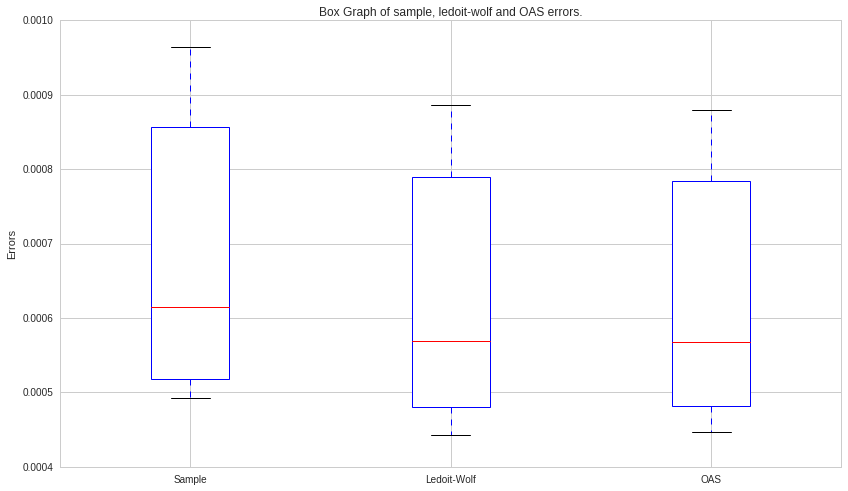

In [158]:
errors = [sample_error, lw_error, oas_error]

plt.boxplot(errors, patch_artist = True)
plt.xticks([1, 2, 3], ['Sample', 'Ledoit-Wolf', 'OAS'])
plt.title('Box Graph of sample, ledoit-wolf and OAS errors.')
plt.ylabel('Errors');

----

# Mean-Variance Portfolio Optimization .
We have shown the increased stability of the shrunk covariance matrix with respect to the sample one. We now set about showing the impact of the shrunk covariance matrix in the context of a portfolio.
##Solving the mean-variance problem.
The mean-variance optimization, developed by Markowitz in 1952 is a very popular portfolio optimization technique, which seeks to maximize returns by minimizing volatility (risk). *You can read more about it and modern portfolio theory [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).*  

The idea behind it boils down to one convex equation:   

$$
\text{Minimizing : } w' \Sigma w
$$ 

$$
\text{Such That} : \left\{
                \begin{array}{}
                  w' \textbf{1} = 0 \textit{ (optional)}\\
                 |w| \leq \textit{max_position}\\
                 w'\textbf{1} \leq \textit{max_leverage} \\
                \end{array}
              \right.            
$$

The term to minimize is called the **objective** and the terms in brackets are the **constraints** we need to abide by. Using the `cvxpy` library we can define a function that solves the convex equation for us.   

We define the `get_markowitz_weights()` function as the convex formula solver. You can find out more about how to use `cvxpy` to solve convex equations [here](http://www.cvxpy.org/en/latest/tutorial/index.html).  

Our objective is to maximize rewards, which we can define as Returns - Risk, given the constraint all asset must have an upper bound such that all capital is not distributed to one asset, and that the total weights should be less than or equal to one.

In [228]:
import cvxpy

def get_markowitz_weights(mu, Sigma, gamma=1, max_position=0.50, max_leverage=1.0):
    # Define w as the variable to find of shape len(Sigma)
    # g and L are parameters to be determined by the user. 
    w = cvxpy.Variable(len(Sigma))
    g = cvxpy.Parameter(sign='positive')
    L = cvxpy.Parameter()
    g.value = gamma
    L.value = max_leverage
    # Try transpose or regular mu vector to satisfy matrix multiplication rules. 
    try:
        ret = mu.T*w
    except ValueError:
        ret = mu*w
    
    # Calculate Risk as x' Sigma x
    risk = cvxpy.quad_form(w, Sigma)
    
    # Find obective : Minimize Risk, equals to maximizing Returns - Risk
    objective = cvxpy.Maximize(ret - g*risk)
    # Setting Constraints:
    # Weight of each asset cannot surpass max_position
    # Sum of the weights must be less or equal 1 : All money need not be invested 
    constraints = [
        cvxpy.abs(w) < max_position,
        cvxpy.norm(w, 1) <= L, 
    ]
    
    # Solv problem
    prob = cvxpy.Problem(
        objective,
        constraints
    )
    
    result = prob.solve()
    
    #Return value of weights. 
    return w.value

##Portfolio Optimization
Running our `get_markowitz_weights()` function with the appropriate parameters allows us to find the weights associated with each asset in our portfolio as a percentage of our capital.   
To make it more of a real world application, we generate a list of 53 assets *(In an algorithm, it is often the case that our number of assets surpass our observations. We attempt to simulate this here)*.     
We begin by collecting the data for the returns of our 53 assets, and calculating their associated covariance matrices using all three methods described above.

In [252]:
# Split list into minute data of frequency days.
symbols = ['SPY', 'XLF', 'XLE', 'XLU','XLK', 'XLI', 'XLB', 'GE', 'GS', 'BRK-A', 'JPM', 'AAPL', 'MMM', 'BA',
           'CSCO','KO', 'DIS','DD', 'XOM', 'INTC', 'IBM', 'NKE', 'MSFT', 'PG', 'UTX', 'HD', 'MCD', 'CVX', 
           'AXP','JNJ', 'MRK', 'CAT', 'PFE', 'TRV', 'UNH', 'WMT', 'VZ', 'QQQ', 'BAC', 'F', 'C', 'CMCSA',
           'MS', 'ORCL', 'PEP', 'HON', 'GILD', 'LMT', 'UPS', 'HP', 'FDX', 'GD', 'SBUX']

data = get_pricing(symbols, 
                   start_date = '2015-01-01', 
                   end_date='2017-01-01', 
                   fields = 'price')
data.columns = map(lambda x: x.symbol, data.columns)
returns = data.pct_change()[1:]
monthly_returns = returns.resample('1M').mean() #Monthly resampling

# Generate empty lists of the sample, shrunk, oas, and lw covariance matrices. 
sample_covs = []
oas_covs = []
lw_covs = []
dates = monthly_returns.index

for i in range(1, len(dates)):
    sample_cov = returns[dates[i-1]:dates[i]].cov().values
    sample_covs.append(sample_cov)

    oas_cov, oas_const = sc.oas(returns[dates[i-1]:dates[i]], assume_centered = False)
    oas_covs.append(oas_cov)
    
    lw_cov, lw_const = sc.ledoit_wolf(returns[dates[i-1]:dates[i]], assume_centered = False)
    lw_covs.append(lw_cov)      

mus = []
for i in range(0, len(dates)):
    mu_returns = monthly_returns.values[i]
    mus.append(mu_returns)

Now that we have computed the three covariance matrices, and the average monthly returns, we can set about using our function to find the weights associated with each asset in our portfolio.

In [254]:
# Using get_markowitz_weights() to find weights associated with assets. 
sample_weights = []
oas_weights = []
lw_weights = []
for i in range(0, len(dates)-1):
    sample_weight = get_markowitz_weights(mus[i], sample_covs[i])
    sample_weights.append(sample_weight)
    
    oas_weight = get_markowitz_weights(mus[i], oas_covs[i])
    oas_weights.append(oas_weight)
    
    lw_weight = get_markowitz_weights(mus[i], lw_covs[i])
    lw_weights.append(lw_weight)

# Printing weights associated with the one asset in the first month. 
print 'Weight of first asset on:\n', 
print 'Sample weight:', sample_weights[4][0]
print 'OAS weight:', oas_weights[4][0]

Weight of first asset on:
Sample weight: [[  7.07186973e-12]]
OAS weight: [[  3.30056297e-12]]


We have only printed the weights associated with the first asset for the first month using both the shrunk and the Ledoit covariance. Immediately  we see a discrepancy  in the output weights for the same asset. We can next verify if the OAS and Ledoit methods are indeed better estimator for the covariance matrix. 

##Verifications
To quantify the accuracy of each covariance matrix, we calculate the mean absolute error using the same formula from earlier in the lecture. Once again, we are looking for an estimated covariance matrix that varies the least in time as this results in fewer turnover rates, decreased transaction costs and increased revenue. 

In [269]:
# Calculating the mean absolute error    
sample_errors = []
oas_errors = []
lw_errors = []
for i in range(1, len(sample_weights)):
    sample_error = np.mean((abs(np.subtract(sample_covs[i-1], sample_covs[i]))))
    sample_errors.append(sample_error)
    
    oas_error = np.mean((abs(np.subtract(oas_covs[i-1], oas_covs[i]))))
    oas_errors.append(oas_error)
    
    lw_error = np.mean((abs(np.subtract(lw_covs[i-1], lw_covs[i]))))
    lw_errors.append(lw_error)
    
print 'mean error associated with sample matrix:', np.mean(sample_errors)
print 'mean error associated with Ledoit matrix:', np.mean(lw_errors)
print 'mean error associated with oas matrix:', np.mean(oas_errors) 

mean error associated with sample matrix: 6.97948557219e-05
mean error associated with Ledoit matrix: 5.50076264567e-05
mean error associated with oas matrix: 5.71533901574e-05


Graphing the mean absolute errors allows us to visualize the movements of the covariance matrices, and allows us conclusively to state that as hoped, the shrunk covariance matrices vary less than those of the sample. 

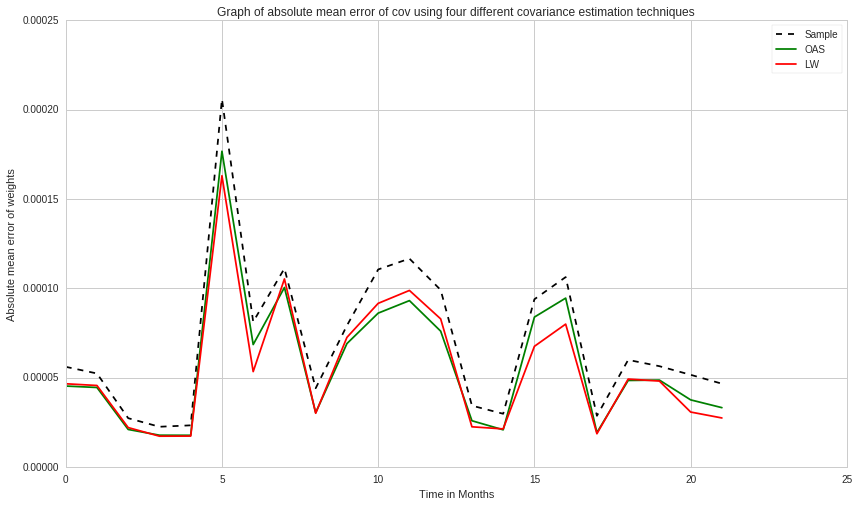

In [241]:
# Plotting graph of errors. 
plt.plot(sample_errors, label = 'Sample', color = 'black', linestyle = 'dashed')
plt.plot(oas_errors, label = 'OAS', color = 'Green')
plt.plot(lw_errors, label = 'LW', color = 'Red')
plt.title('Graph of absolute mean error of cov using four '+
          'different covariance estimation techniques')
plt.ylabel('Absolute mean error of weights')
plt.xlabel('Time in Months')
plt.legend();

We next check the usefulness of our estimation by checking the mean error associated with the weights calculated above.  
Bellow, we calculate and graph the errors of two assets in our portfolio over time to compare them, checking if the weights associated with the shrunk covariance matrices have less error than the sample ones. 

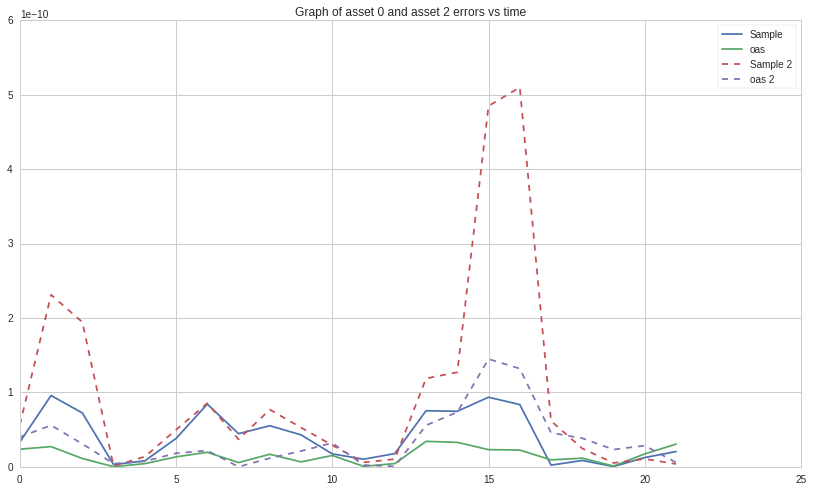

In [242]:
# Calculating the error associated with the weights found using the four different covariance techniques
# For one asset. 

asset1_sample_weights_diffs = []
asset1_oas_weights_diffs = []
asset1_lw_weights_diffs = []

for i in range(1, len(dates)-1):
    asset1_sample_weights_diff = abs(np.subtract(sample_weights[i-1][0], sample_weights[i][0]))
    asset1_sample_weights_diffs.append(asset1_sample_weights_diff)

    asset1_oas_weights_diff = abs(np.subtract(oas_weights[i-1][0], oas_weights[i][0]))
    asset1_oas_weights_diffs.append(asset1_oas_weights_diff)

    asset1_lw_weights_diff = abs(np.subtract(lw_weights[i-1][0], lw_weights[i][0]))
    asset1_lw_weights_diffs.append(asset1_lw_weights_diff)
    
asset1_sample_weights_diffs = np.ndarray.flatten(np.array(asset1_sample_weights_diffs))
asset1_oas_weights_diffs = np.ndarray.flatten(np.array(asset1_oas_weights_diffs))
asset1_lw_weights_diffs = np.ndarray.flatten(np.array(asset1_lw_weights_diffs))

plt.plot(asset1_sample_weights_diffs, label = 'Sample')
plt.plot(asset1_oas_weights_diffs, label = 'oas')
#plt.plot(asset1_lw_weights_diffs, label = 'lw')

# For a second asset. 
asset2_sample_weights_diffs = []
asset2_oas_weights_diffs = []
asset2_lw_weights_diffs = []   
for i in range(1, len(dates)-1):
    a = 4
    asset2_sample_weights_diff = abs(np.subtract(sample_weights[i-1][a], sample_weights[i][a]))
    asset2_sample_weights_diffs.append(asset2_sample_weights_diff)

    asset2_oas_weights_diff = abs(np.subtract(oas_weights[i-1][a], oas_weights[i][a]))
    asset2_oas_weights_diffs.append(asset2_oas_weights_diff)

    asset2_lw_weights_diff = abs(np.subtract(lw_weights[i-1][a], lw_weights[i][a]))
    asset2_lw_weights_diffs.append(asset2_lw_weights_diff)    
    
asset2_sample_weights_diffs = np.ndarray.flatten(np.array(asset2_sample_weights_diffs))
asset2_oas_weights_diffs = np.ndarray.flatten(np.array(asset2_oas_weights_diffs))
asset2_lw_weights_diffs = np.ndarray.flatten(np.array(asset2_lw_weights_diffs))

plt.plot(asset2_sample_weights_diffs, label = 'Sample 2', linestyle = 'dashed')
plt.plot(asset2_oas_weights_diffs, label = 'oas 2',linestyle = 'dashed')
#plt.plot(asset2_lw_weights_diffs, label = 'lw 2',linestyle = 'dashed')
plt.title('Graph of asset 0 and asset 2 errors vs time')
plt.legend();

To check the validity of our statement on the usefulness of the shrinkage, and conclude on the usefulness of the estimated covariance matrices, we calculate the mean error associated with the weights for asset1 and asset2, along with its variance. We would like the variance of the weights using the shrinkage method to be lower than that of the sample one, indicating less movement in time. 

In [265]:
mean_sample_weights_diffs = []
mean_oas_weights_diffs = []
mean_lw_weights_diffs = []   

for i in range(1, len(dates)-1):
    mean_sample_weights_diff = np.mean(sum(abs(np.subtract(sample_weights[i-1], sample_weights[i]))))
    mean_sample_weights_diffs.append(mean_sample_weights_diff)
    
    mean_oas_weights_diff = np.mean(sum(abs(np.subtract(oas_weights[i-1], oas_weights[i]))))
    mean_oas_weights_diffs.append(mean_oas_weights_diff)

    mean_lw_weights_diff = np.mean(sum(abs(np.subtract(lw_weights[i-1], lw_weights[i]))))
    mean_lw_weights_diffs.append(mean_lw_weights_diff)  
    
print 'mean error associated with Sample covariance: ', np.mean(mean_sample_weights_diffs)
print 'mean error associated with lw covariance: ', np.mean(mean_lw_weights_diffs)
print 'mean error assocaited with oas covariance: ', np.mean(mean_oas_weights_diffs)

mean error associated with Sample covariance:  1.92765002197
mean error associated with lw covariance:  1.90200244924
mean error assocaited with oas covariance:  1.91251786038


We can see that the mean errors associated with the shrunk techniques are lower than those of the sample.  
This shows us that the sample matrix is more unstable than that of the shrunk ones, and that shrinking the covariance matrix in the case of mean-variance optimization would lead to better returns as a direct consequence of decreased turnover rates.
Note : Our example only used 50 assets, in the event of even more assets, comparable to outcomes of an algorithm, the Ledoit-Wolf and OAS methods would perform even better as the number of assets approaches the number of observations.

----

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*